# 迁移学习介绍
https://www.bilibili.com/video/BV13W41187uW/?spm_id_from=333.337.search-card.all.click&vd_source=7f66fbe614579924683a39f37283d31f

领域自适应（domain adaptation),同构迁移学习，有标签的源域和无标签的目标域共享相同的特征和类别，但是特征分布不同如何用源域定义目标域
1.概率分布相似，最小化概率分布距离：概率分布适配法（distribution adaptation）
    边缘分布适配
        迁移成分分析TCA，最大均值差异MMD
    条件分布适配
    联合分布适配 
  数据整体差异性大，相似度较低，边缘分布更重要，反之条件 
2.共享某些特征，选择出公共特征：特征选择法（feature selection）
    通常与分布适配相结合，利用稀疏矩阵（如L2番薯）
3.共享某些子空间，将两个域变换到相同的子空间：子空间学习法（subspace learning）
    统计特征变换：统计特征进行变换对齐
    流形学习：流形空间中进行子空间变换

### DANN
https://blog.csdn.net/weijie_home/article/details/119921964
域对抗神经网络DANN，训练的最终目的是最大化标签分类的准确率、最小化域分类能力，也就是让下面的域分类器分不出来现在的数据属于哪个域，这样就可以说明对于这个网络两个域已经足够接近，抹去了域的区别作用

参考https://github.com/Yangyangii/DANN-pytorch/blob/master/DANN.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.autograd import Function
import numpy as np
import datetime

In [81]:
# 定义图像预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5])])

# 定义数据集
data_train = './train_data/'
batch_size = 128

train_dataset = datasets.ImageFolder(root=data_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4,drop_last=True)

In [82]:
target_path = './test_data/'
target_dataset = datasets.ImageFolder(root=target_path, transform=transform)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=4,drop_last=True)

In [63]:
class GradientReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=5, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.RReLU(inplace=True),
                )
        self.label_classifier = nn.Sequential(
             nn.Dropout(p=0.2),
             nn.Linear(in_features=128*6*6, out_features=2048),
             nn.RReLU(inplace=True),
             nn.Linear(in_features=2048, out_features=1024),
             nn.RReLU(inplace=True),
             nn.Linear(in_features=1024, out_features=9),  
                )
        
        self.domain_classifier = nn.Sequential(
            nn.Linear(in_features=128*6*6, out_features=1024),
            nn.RReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.RReLU(inplace=True),
            nn.Linear(1024, 2),
                )
    def forward(self, x, alpha=None):
        x = self.feature(x)
        feature = x.view(x.shape[0],-1)
        label_output = self.label_classifier(feature)
        
        feature = GradientReverse.apply(feature,alpha)  
        domain_output = self.domain_classifier(feature)
        return label_output,domain_output
        

#### 训练分类器

In [8]:
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
#model.load_state_dict(torch.load('cnn_model.pth', map_location = device))

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion_label = nn.CrossEntropyLoss()
criterion_domain = nn.BCEWithLogitsLoss()

In [10]:
num_epochs = 50
for epoch in range(num_epochs):
    for inputs_source, labels_source in train_loader:
        # 将域分类器的参数冻结
        for param in model.domain_classifier.parameters():
            param.requires_grad = False

        # 将标签分类器的参数梯度归零
        optimizer.zero_grad()
        inputs_source = inputs_source.to(device)
        labels_source = labels_source.to(device)
        # 源领域数据的标签分类
        x= model.feature(inputs_source)
        x = x.view(x.shape[0],-1)
        outputs_label_source = model.label_classifier(x)
        loss_label_source = criterion_label(outputs_label_source, labels_source)

        # 反向传播和优化
        loss_label_source.backward()
        optimizer.step()

    # 输出每个 epoch 结束后的标签分类损失
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss_label_source.item()}")

Epoch 1/50, Loss: 1.3823697566986084
Epoch 2/50, Loss: 1.0636852979660034
Epoch 3/50, Loss: 1.4271458387374878
Epoch 4/50, Loss: 0.35322442650794983
Epoch 5/50, Loss: 0.7741248607635498
Epoch 6/50, Loss: 0.37413763999938965
Epoch 7/50, Loss: 0.23547735810279846
Epoch 8/50, Loss: 0.29128971695899963
Epoch 9/50, Loss: 0.28832411766052246
Epoch 10/50, Loss: 0.4247492849826813
Epoch 11/50, Loss: 0.17036691308021545
Epoch 12/50, Loss: 0.3130476772785187
Epoch 13/50, Loss: 0.09905990958213806
Epoch 14/50, Loss: 0.11362544447183609
Epoch 15/50, Loss: 0.0648907944560051
Epoch 16/50, Loss: 0.16286884248256683
Epoch 17/50, Loss: 0.1715889275074005
Epoch 18/50, Loss: 0.0035594855435192585
Epoch 19/50, Loss: 0.07776525616645813
Epoch 20/50, Loss: 0.3497534990310669
Epoch 21/50, Loss: 0.17155703902244568
Epoch 22/50, Loss: 0.05805962160229683
Epoch 23/50, Loss: 0.024460557848215103
Epoch 24/50, Loss: 0.015760211274027824
Epoch 25/50, Loss: 0.6203153729438782
Epoch 26/50, Loss: 0.0007166838040575385

In [11]:
torch.save(model.state_dict(), "label_classifier.pth")

#### 可视化

In [13]:
#model.load_state_dict(torch.load('label_classifier.pth', map_location = device))

# 仅提取特征的新模型
feature_extractor = model.feature

# 设置为评估模式
feature_extractor_model.eval()

source_features = []
target_features = []
# 禁用梯度计算
with torch.no_grad():
    # 遍历数据加载器，提取源领域数据的特征
    for inputs, labels in train_loader:
        #源域
        inputs, labels = inputs.to(device), labels.to(device)
        features = feature_extractor(inputs)
        source_features.append(features)
        
        #目标域
        inputs_target, _ = next(iter(target_loader))
        inputs_target= inputs_target.to(device)
        features = feature_extractor(inputs_target)
        target_features.append(features)       

# 将特征拼接成一个张量
source_features = torch.cat(source_features)
target_features = torch.cat(target_features)

source_features_1d = source_features.view(source_features.size(0), -1)
target_features_1d = target_features.view(target_features.size(0), -1)

# 打印提取的特征的形状
print( source_features_1d.shape,target_features_1d.shape)

torch.Size([4500, 4608]) torch.Size([4544, 4608])


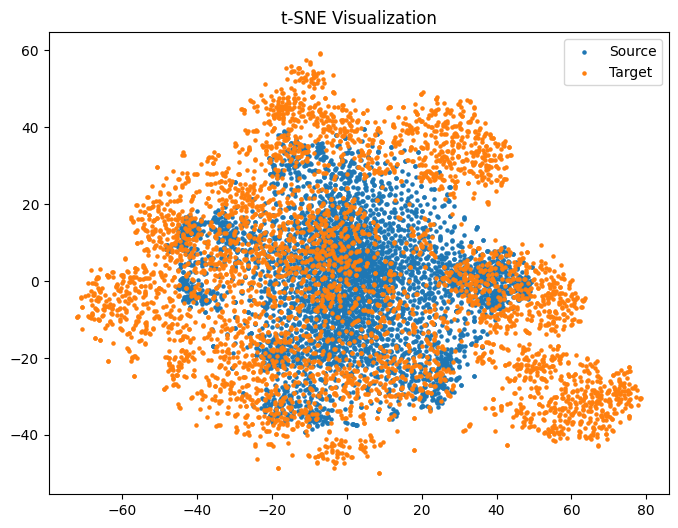

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")
# 初始化 t-SNE 模型
tsne = TSNE(n_components=2)

source_features_1d = source_features_1d.to(device)
target_features_1d = target_features_1d.to(device)

# 对数据进行降维
so = tsne.fit_transform(source_features_1d)
ta = tsne.fit_transform(target_features_1d)

# 绘制降维后的数据
plt.figure(figsize=(8, 6))
plt.scatter(so[:, 0], so[:, 1], s=5,label='Source')  
plt.scatter(ta[:, 0], ta[:, 1], s=5,label='Target')  

plt.legend()
plt.title('t-SNE Visualization')
plt.show()


#### 训练对抗网络

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
#model.load_state_dict(torch.load('label_classifier.pth', map_location = device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion_label = nn.CrossEntropyLoss()
criterion_domain =  nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()

In [90]:
#设置运行参数
loss_ds = []
loss_dt = []
loss_l = []
max_epoch = 100

In [91]:
#训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(max_epoch):
    p = epoch/max_epoch
    alpha = 2. / (1+np.exp(-10.*p)) - 1.
    for param_groups in optimizer.param_groups:
        param_groups['lr'] = 1e-3/(1+10*p)**0.75
    for inputs_source, labels_source in train_loader:
        inputs_target, _ = next(iter(target_loader))
        inputs_source = inputs_source.to(device)
        labels_source = labels_source.to(device)
        inputs_target = inputs_target.to(device)
        
        model.zero_grad()
        
        # 源数据
        outputs_label_source,outputs_domain_source = model(inputs_source,alpha = alpha)
        loss_label_source = criterion_label(outputs_label_source, labels_source)
        domain_labels = torch.zeros(len(inputs_source)).long().to(device)
        loss_domain_source = criterion_domain(outputs_domain_source,domain_labels)
        
        #目标数据
        domain_labels = torch.ones(len(inputs_target)).long().to(device)
        _,outputs_domain_target = model(inputs_target,alpha = alpha)
        loss_domain_target = criterion_domain(outputs_domain_target,domain_labels)
        
        #总loss
        loss_total = loss_domain_source+0.6*(loss_domain_target+loss_label_source)
        
        loss_total.backward()
        optimizer.step()

        loss_ds.append(loss_domain_source.item())
        loss_dt.append(loss_domain_target.item())
        loss_l.append(loss_label_source.item())

   
    dt = datetime.datetime.now().strftime('%H:%M:%S')
    print('{},Epoch: {}/{}, Loss_ds: {:.4f},Loss_dt: {:.4f},Loss_l: {:.4f}'.format(dt,epoch,max_epoch,loss_domain_source.item(),loss_domain_target.item(), loss_label_source.item()))
    if epoch%10==9:
        torch.save(model.state_dict(), "DaNN.pth")

01:29:09,Epoch: 0/100, Loss_ds: 0.0051,Loss_dt: 0.0005,Loss_l: 1.2615
01:29:26,Epoch: 1/100, Loss_ds: 0.0651,Loss_dt: 0.0536,Loss_l: 0.9945
01:29:43,Epoch: 2/100, Loss_ds: 0.0017,Loss_dt: 0.0046,Loss_l: 1.0337
01:29:59,Epoch: 3/100, Loss_ds: 0.0678,Loss_dt: 0.0290,Loss_l: 0.9504
01:30:16,Epoch: 4/100, Loss_ds: 0.0253,Loss_dt: 0.0712,Loss_l: 0.7299
01:30:32,Epoch: 5/100, Loss_ds: 0.1887,Loss_dt: 0.1554,Loss_l: 1.0714
01:30:48,Epoch: 6/100, Loss_ds: 0.0203,Loss_dt: 0.0141,Loss_l: 0.7514
01:31:05,Epoch: 7/100, Loss_ds: 0.0233,Loss_dt: 0.0137,Loss_l: 0.5476
01:31:22,Epoch: 8/100, Loss_ds: 0.1937,Loss_dt: 1.1445,Loss_l: 1.2643
01:31:38,Epoch: 9/100, Loss_ds: 0.0687,Loss_dt: 0.1876,Loss_l: 0.9877
01:31:55,Epoch: 10/100, Loss_ds: 0.0709,Loss_dt: 0.0572,Loss_l: 0.5534
01:32:13,Epoch: 11/100, Loss_ds: 0.0970,Loss_dt: 0.3646,Loss_l: 0.7938
01:32:29,Epoch: 12/100, Loss_ds: 0.3786,Loss_dt: 0.2314,Loss_l: 0.9843
01:32:46,Epoch: 13/100, Loss_ds: 0.0256,Loss_dt: 0.0253,Loss_l: 0.8687
01:33:03,Epoch: 

Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-7ed_fvz6'


01:35:50,Epoch: 24/100, Loss_ds: 0.0008,Loss_dt: 0.0042,Loss_l: 0.4115
01:36:07,Epoch: 25/100, Loss_ds: 0.0002,Loss_dt: 0.0016,Loss_l: 0.4692
01:36:23,Epoch: 26/100, Loss_ds: 0.0013,Loss_dt: 0.0008,Loss_l: 0.3075
01:36:40,Epoch: 27/100, Loss_ds: 0.0001,Loss_dt: 0.0017,Loss_l: 0.2923
01:36:57,Epoch: 28/100, Loss_ds: 0.0024,Loss_dt: 0.0013,Loss_l: 0.1197
01:37:14,Epoch: 29/100, Loss_ds: 0.0008,Loss_dt: 0.0011,Loss_l: 0.1511
01:37:30,Epoch: 30/100, Loss_ds: 0.0001,Loss_dt: 0.0013,Loss_l: 0.1324
01:37:47,Epoch: 31/100, Loss_ds: 0.0002,Loss_dt: 0.0013,Loss_l: 0.1347
01:38:04,Epoch: 32/100, Loss_ds: 0.0004,Loss_dt: 0.0013,Loss_l: 0.1079
01:38:21,Epoch: 33/100, Loss_ds: 0.0001,Loss_dt: 0.0059,Loss_l: 0.0533
01:38:38,Epoch: 34/100, Loss_ds: 0.2694,Loss_dt: 0.0021,Loss_l: 0.1197


Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8oxyvc0m'


01:38:56,Epoch: 35/100, Loss_ds: 0.1317,Loss_dt: 0.0769,Loss_l: 1.1434
01:39:14,Epoch: 36/100, Loss_ds: 0.0618,Loss_dt: 0.0194,Loss_l: 0.6548
01:39:30,Epoch: 37/100, Loss_ds: 0.0040,Loss_dt: 0.0096,Loss_l: 0.6280
01:39:47,Epoch: 38/100, Loss_ds: 0.0007,Loss_dt: 0.0056,Loss_l: 0.2618
01:40:03,Epoch: 39/100, Loss_ds: 0.0005,Loss_dt: 0.0008,Loss_l: 0.3546


Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-zs1g9d7_'


01:40:19,Epoch: 40/100, Loss_ds: 0.0008,Loss_dt: 0.0019,Loss_l: 0.2292
01:40:36,Epoch: 41/100, Loss_ds: 0.0016,Loss_dt: 0.0012,Loss_l: 0.1713
01:40:52,Epoch: 42/100, Loss_ds: 0.0012,Loss_dt: 0.0017,Loss_l: 0.1486
01:41:09,Epoch: 43/100, Loss_ds: 0.0000,Loss_dt: 0.0012,Loss_l: 0.1147
01:41:26,Epoch: 44/100, Loss_ds: 0.0001,Loss_dt: 0.0013,Loss_l: 0.0537
01:41:41,Epoch: 45/100, Loss_ds: 0.0002,Loss_dt: 0.0008,Loss_l: 0.1415
01:41:59,Epoch: 46/100, Loss_ds: 0.0000,Loss_dt: 0.0007,Loss_l: 0.0609
01:42:16,Epoch: 47/100, Loss_ds: 0.0000,Loss_dt: 0.0004,Loss_l: 0.1362
01:42:32,Epoch: 48/100, Loss_ds: 0.0005,Loss_dt: 0.0003,Loss_l: 0.0246
01:42:48,Epoch: 49/100, Loss_ds: 0.0001,Loss_dt: 0.0004,Loss_l: 0.0194
01:43:04,Epoch: 50/100, Loss_ds: 0.0007,Loss_dt: 0.0004,Loss_l: 0.0425
01:43:21,Epoch: 51/100, Loss_ds: 0.0000,Loss_dt: 0.0004,Loss_l: 0.0337


Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/environment/miniconda3/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-uwaa6kut'


01:43:38,Epoch: 52/100, Loss_ds: 0.0000,Loss_dt: 0.0002,Loss_l: 0.0194
01:43:55,Epoch: 53/100, Loss_ds: 0.0000,Loss_dt: 0.0003,Loss_l: 0.0196
01:44:13,Epoch: 54/100, Loss_ds: 0.0002,Loss_dt: 0.0002,Loss_l: 0.0129
01:44:30,Epoch: 55/100, Loss_ds: 0.0001,Loss_dt: 0.0002,Loss_l: 0.0173
01:44:48,Epoch: 56/100, Loss_ds: 0.0001,Loss_dt: 0.0002,Loss_l: 0.0308
01:45:05,Epoch: 57/100, Loss_ds: 0.0008,Loss_dt: 0.0001,Loss_l: 0.0093
01:45:22,Epoch: 58/100, Loss_ds: 0.0000,Loss_dt: 0.0002,Loss_l: 0.0042
01:45:41,Epoch: 59/100, Loss_ds: 0.0001,Loss_dt: 0.0003,Loss_l: 0.0159
01:45:59,Epoch: 60/100, Loss_ds: 0.0004,Loss_dt: 0.0002,Loss_l: 0.0039
01:46:15,Epoch: 61/100, Loss_ds: 0.0001,Loss_dt: 0.0002,Loss_l: 0.0050
01:46:32,Epoch: 62/100, Loss_ds: 0.0000,Loss_dt: 0.0002,Loss_l: 0.0214
01:46:47,Epoch: 63/100, Loss_ds: 0.0001,Loss_dt: 0.0001,Loss_l: 0.0018
01:47:04,Epoch: 64/100, Loss_ds: 0.0000,Loss_dt: 0.0002,Loss_l: 0.0260
01:47:21,Epoch: 65/100, Loss_ds: 0.0001,Loss_dt: 0.0001,Loss_l: 0.0085
01:47:

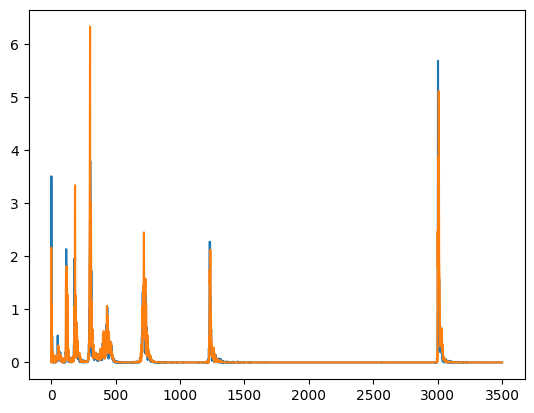

In [92]:
import matplotlib.pyplot as plt
plt.plot(loss_ds)
plt.plot(loss_dt)

In [93]:
# 测试模型并保存预测结果
import pandas as pd
device = torch.device("cpu")
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=4) #顺序
model.to(device)
model.eval()  
all_predictions = []
with torch.no_grad():
    for batch,_ in target_loader:
        inputs = batch.to(device)
        outputs,_ = model(inputs,1)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())

# 将预测结果保存到 DataFrame
result_df = pd.DataFrame({'id':np.arange(100000),'label': all_predictions})

# 保存 DataFrame 到 CSV 文件
result_df.to_csv('res.csv', index=False)

In [94]:
#model.load_state_dict(torch.load('label_classifier.pth', map_location = device))

# 仅提取特征的新模型
feature_extractor = model.feature

# 设置为评估模式
feature_extractor_model.eval()

source_features = []
target_features = []
# 禁用梯度计算
with torch.no_grad():
    # 遍历数据加载器，提取源领域数据的特征
    for inputs, labels in train_loader:
        #源域
        inputs, labels = inputs.to(device), labels.to(device)
        features = feature_extractor(inputs)
        source_features.append(features)
        
        #目标域
        inputs_target, _ = next(iter(target_loader))
        inputs_target= inputs_target.to(device)
        features = feature_extractor(inputs_target)
        target_features.append(features)       

# 将特征拼接成一个张量
source_features = torch.cat(source_features)
target_features = torch.cat(target_features)

source_features_1d = source_features.view(source_features.size(0), -1)
target_features_1d = target_features.view(target_features.size(0), -1)

# 打印提取的特征的形状
print( source_features_1d.shape,target_features_1d.shape)

torch.Size([4480, 4608]) torch.Size([4480, 4608])


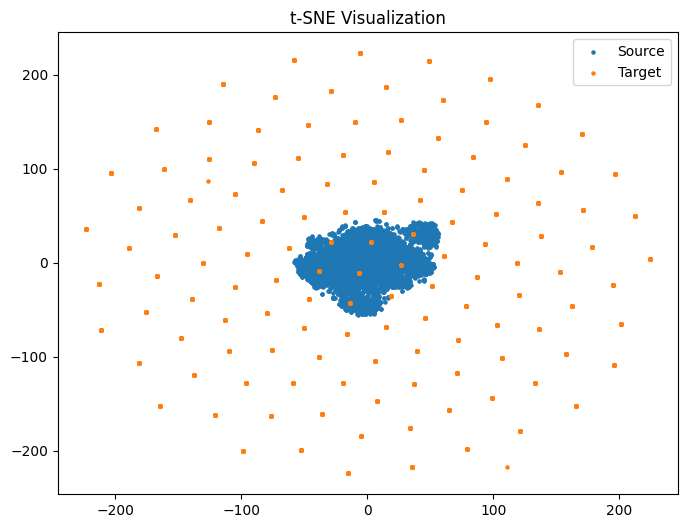

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")
# 初始化 t-SNE 模型
tsne = TSNE(n_components=2)

source_features_1d = source_features_1d.to(device)
target_features_1d = target_features_1d.to(device)

# 对数据进行降维
so = tsne.fit_transform(source_features_1d)
ta = tsne.fit_transform(target_features_1d)

# 绘制降维后的数据
plt.figure(figsize=(8, 6))
plt.scatter(so[:, 0], so[:, 1], s=5,label='Source')  
plt.scatter(ta[:, 0], ta[:, 1], s=5,label='Target')  

plt.legend()
plt.title('t-SNE Visualization')
plt.show()
